<a href="https://colab.research.google.com/github/Metaphysicist1/Traffic-Data-Time-Series-Forecasting/blob/main/Spatio_Temporal_GCN_for_Traffic_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, Layer, Lambda, ReLU
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt



In [ ]:
# Data Loading and Preprocessing

def load_data():
    """
    Loads the PEMS-08 data and constructs the distance matrix from the CSV file.
    This function is updated to use both pems08.npz and distance.csv.
    """
    npz_file = 'pems08.npz'
    distance_csv = 'distance.csv'

    # Check if files exist
    if not os.path.exists(npz_file) or not os.path.exists(distance_csv):
        raise FileNotFoundError(
            f"Ensure both '{npz_file}' and '{distance_csv}' are in the directory."
        )

    with np.load(npz_file) as data:
        # Shape: (timestamps, num_sensors, features)
        traffic_data = data['data']
        num_sensors = traffic_data.shape[1]

    # Read the distance CSV file
    distance_df = pd.read_csv(distance_csv)

    # Initialize a square distance matrix with infinity
    dist_mx = np.full((num_sensors, num_sensors), np.inf, dtype=np.float32)

    # Set the diagonal to 0
    np.fill_diagonal(dist_mx, 0)

    # Populate the matrix from the dataframe
    for _, row in distance_df.iterrows():
        from_node, to_node, distance = int(row['from']), int(row['to']), row['cost']
        if from_node < num_sensors and to_node < num_sensors:
            dist_mx[from_node, to_node] = distance
            dist_mx[to_node, from_node] = distance # Ensure symmetry

    return traffic_data, dist_mx

def get_normalized_adj(adj_mx, sigma2=0.1, epsilon=0.5):
    """
    Computes the normalized adjacency matrix for graph convolutions.
    A = D^{-1/2} * A * D^{-1/2}
    """
    # Calculate the adjacency matrix using a Gaussian kernel
    distances = adj_mx[~np.isinf(adj_mx)].flatten()
    std = distances.std()
    adj = np.exp(-np.square(adj_mx / std))
    adj[adj < epsilon] = 0 # Apply threshold

    # Add self-connections
    adj = adj + np.identity(adj.shape[0])

    # Calculate degree matrix and its inverse square root
    d = np.sum(adj, axis=1)
    d_inv_sqrt = np.power(d, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)

    # Normalize the adjacency matrix
    normalized_adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
    return normalized_adj

def generate_sequences(data, seq_length, pred_length):
    """
    Generates input sequences and corresponding labels for time series forecasting.
    Now handles multi-feature data.
    """
    x, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x.append(data[i:i+seq_length])
        # We only predict the first feature (traffic flow)
        y.append(data[i+seq_length:i+seq_length+pred_length, :, 0])
    return np.array(x), np.array(y)


In [ ]:

#Model Architecture (STGCN)

class GraphConv(Layer):
    """Custom Graph Convolutional Layer."""
    def __init__(self, filters, adj_matrix, **kwargs):
        super(GraphConv, self).__init__(**kwargs)
        self.filters = filters
        # Convert adjacency matrix to a TensorFlow tensor
        self.adj_matrix = tf.constant(adj_matrix, dtype=tf.float32)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        # Correctly handle 4D tensor (batch, timesteps, sensors, features)
        support = tf.einsum('ij,btjf->btif', self.adj_matrix, inputs)
        output = tf.einsum('btif,fo->btio', support, self.kernel)
        return tf.nn.relu(output) # This is okay inside a custom layer's call method

def stgcn_block(inputs, adj_matrix, filters, kernel_size):
    """A single Spatio-Temporal block."""
    t = Conv2D(filters, kernel_size=(1, kernel_size), padding='same', activation='relu')(inputs)
    s = GraphConv(filters, adj_matrix)(t)
    t2 = Conv2D(filters, kernel_size=(1, kernel_size), padding='same')(s)

    if inputs.shape[-1] != filters:
        residual = Conv2D(filters, kernel_size=(1, 1))(inputs)
    else:
        residual = inputs

    # Corrected Line: Use the Keras ReLU layer instead of the raw TF function
    return ReLU()(residual + t2)

def build_stgcn_model(input_shape, adj_matrix, pred_length):
    """Builds the STGCN model."""
    inputs = Input(shape=input_shape)

    x = stgcn_block(inputs, adj_matrix, filters=64, kernel_size=3)
    x = Dropout(0.3)(x)

    x = stgcn_block(x, adj_matrix, filters=64, kernel_size=3)
    x = Dropout(0.3)(x)

    # Output layer to forecast the 'pred_length' steps for the flow feature.
    # The output of this Conv2D will have shape (batch, timesteps, sensors, 1)
    output = Conv2D(1, kernel_size=(1, 1), activation='linear')(x)

    # Squeeze the last dimension (features) to match the shape of y.
    # Wrap the tf.squeeze operation in a Lambda layer to make it compatible with Keras API.
    squeezed_output = Lambda(lambda z: tf.squeeze(z, axis=-1))(output)

    model = Model(inputs, squeezed_output)
    return model



In [ ]:
# Visualization Functions

def plot_training_history(history):
    """Plots the training and validation loss."""
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss (MAE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_forecasts(model, X_val, y_val, scaler, pred_length, num_plots=5):
    """Visualizes model predictions against actuals."""
    predictions_normalized = model.predict(X_val)

    num_sensors = y_val.shape[2]
    num_features = scaler.scale_.shape[0]

    # Inverse transform predictions
    pred_dummy = np.zeros((predictions_normalized.shape[0], predictions_normalized.shape[1], num_sensors, num_features))
    pred_dummy[:, :, :, 0] = predictions_normalized
    pred_dummy = pred_dummy.reshape(-1, num_features)
    predictions = scaler.inverse_transform(pred_dummy)[:, 0].reshape(predictions_normalized.shape[0], pred_length, num_sensors)

    # Inverse transform actuals
    y_val_dummy = np.zeros((y_val.shape[0], y_val.shape[1], num_sensors, num_features))
    y_val_dummy[:, :, :, 0] = y_val
    y_val_dummy = y_val_dummy.reshape(-1, num_features)
    y_val_unnormalized = scaler.inverse_transform(y_val_dummy)[:, 0].reshape(y_val.shape[0], pred_length, num_sensors)

    for i in range(num_plots):
        random_sensor = np.random.randint(0, num_sensors)
        random_sample_idx = np.random.randint(0, len(X_val))

        plt.figure(figsize=(15, 6))
        plt.plot(predictions[random_sample_idx, :, random_sensor], label='Predicted Flow', marker='o')
        plt.plot(y_val_unnormalized[random_sample_idx, :, random_sensor], label='Actual Flow', marker='x')
        plt.title(f'Traffic Flow Forecast vs. Actual for Sensor #{random_sensor}')
        plt.xlabel('Time Step (5-minute intervals)')
        plt.ylabel('Traffic Flow')
        plt.legend()
        plt.grid(True)
        plt.show()




Loading data...
Data loaded and adjacency matrix computed.
Data normalized using StandardScaler.
Generating sequences...
Sequence generation complete. X shape: (17833, 12, 170, 3), y shape: (17833, 12, 170)
Data split. Train: 12483, Val: 3566, Test: 1784
Building STGCN model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 12, 170,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 12, 170,   │        640 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_conv_12       │ (None, 12, 170,   │      4,096 │ conv2d_30[0][0]   │
│ (GraphConv)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 12, 170,   │        256 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 12, 170,   │     12,352 │ graph_conv_12[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 12, 170,   │          0 │ conv2d_32[0][0],  │
│                     │ 64)               │            │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 12, 170,   │          0 │ add_9[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 12, 170,   │          0 │ re_lu_4[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 12, 170,   │     12,352 │ dropout_4[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ graph_conv_13       │ (None, 12, 170,   │      4,096 │ conv2d_33[0][0]   │
│ (GraphConv)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 12, 170,   │     12,352 │ graph_conv_13[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 12, 170,   │          0 │ dropout_4[0][0],  │
│                     │ 64)               │            │ conv2d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 12, 170,   │          0 │ add_10[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 12, 170,   │          0 │ re_lu_5[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 12, 170,   │         65 │ dropout_5[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 12, 170)   │          0 │ conv2d_35[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,209 (180.50 KB)

 Trainable params: 46,209 (180.50 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 358s 908ms/step - loss: 0.3401 - val_loss: 0.3103
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 384s 914ms/step - loss: 0.2593 - val_loss: 0.2982
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 344s 880ms/step - loss: 0.2469 - val_loss: 0.2756
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 397s 919ms/step - loss: 0.2363 - val_loss: 0.3138
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 365s 934ms/step - loss: 0.2268 - val_loss: 0.2885
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 378s 924ms/step - loss: 0.2216 - val_loss: 0.2966
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 377s 911ms/step - loss: 0.2170 - val_loss: 0.2601
Epoch 8/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 357s 912ms/step - loss: 0.2118 - val_loss: 0.2464
Epoch 9/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 350s 895ms/step - loss: 0.2094 - val_loss: 0.2559
Epoch 10/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 379s 888ms/step - loss: 0.2060 - val_loss: 0.2299
Epoch 11/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 352s 899ms/step - loss: 0.2040

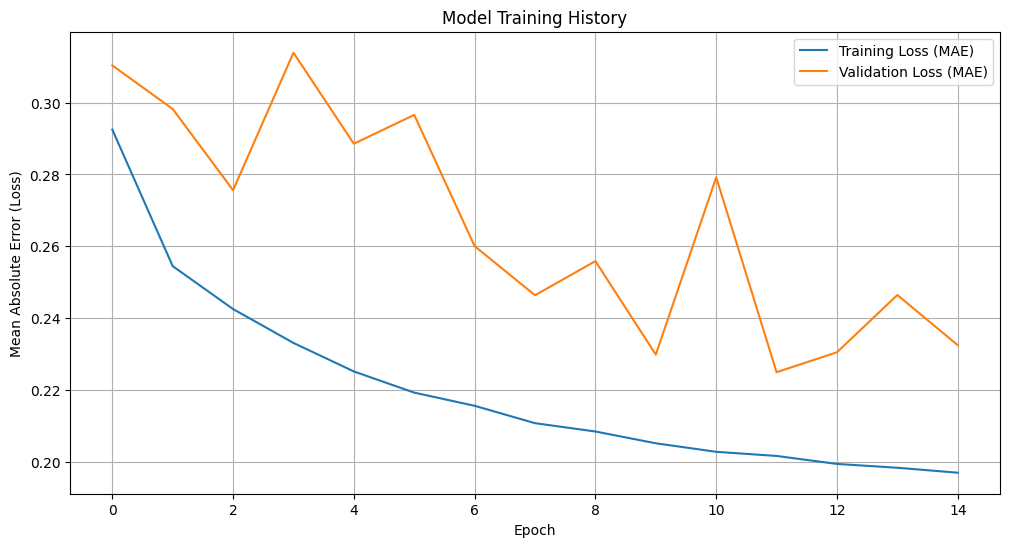

56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 277ms/step


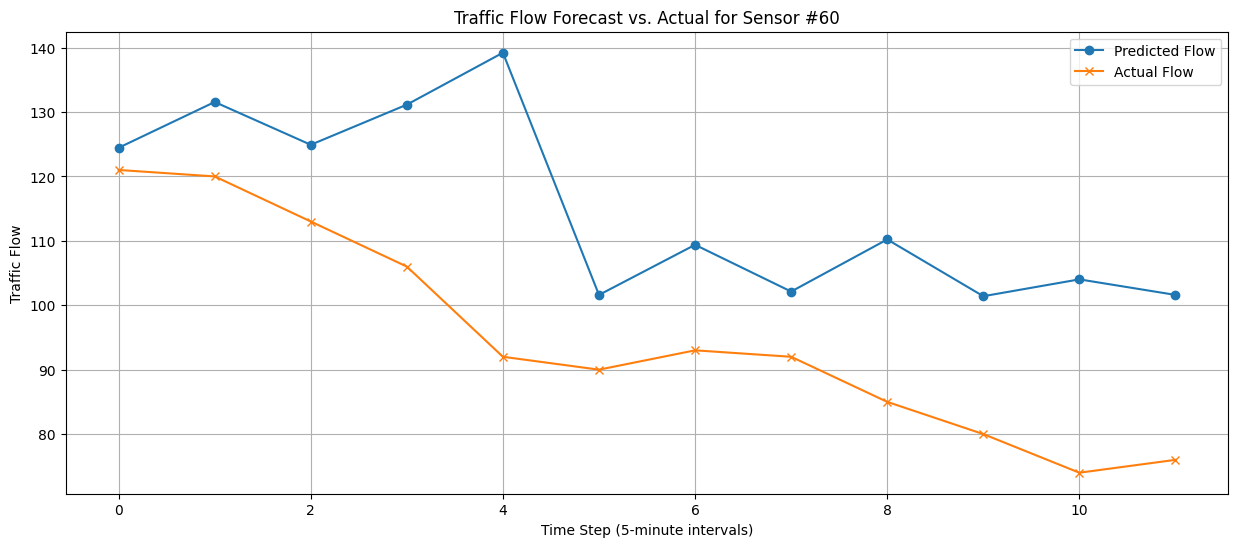

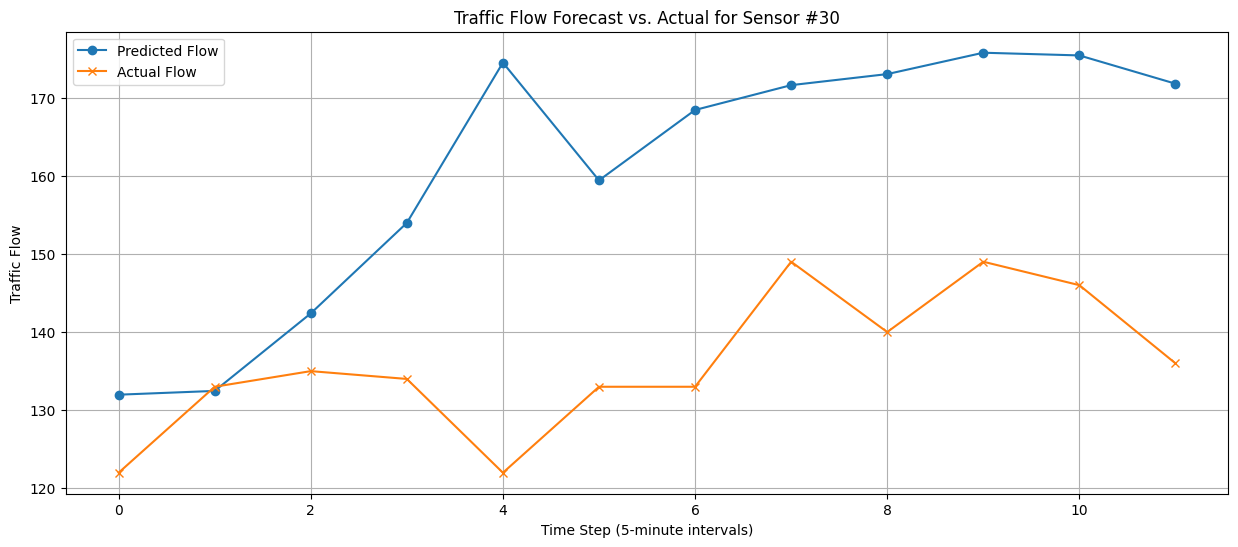

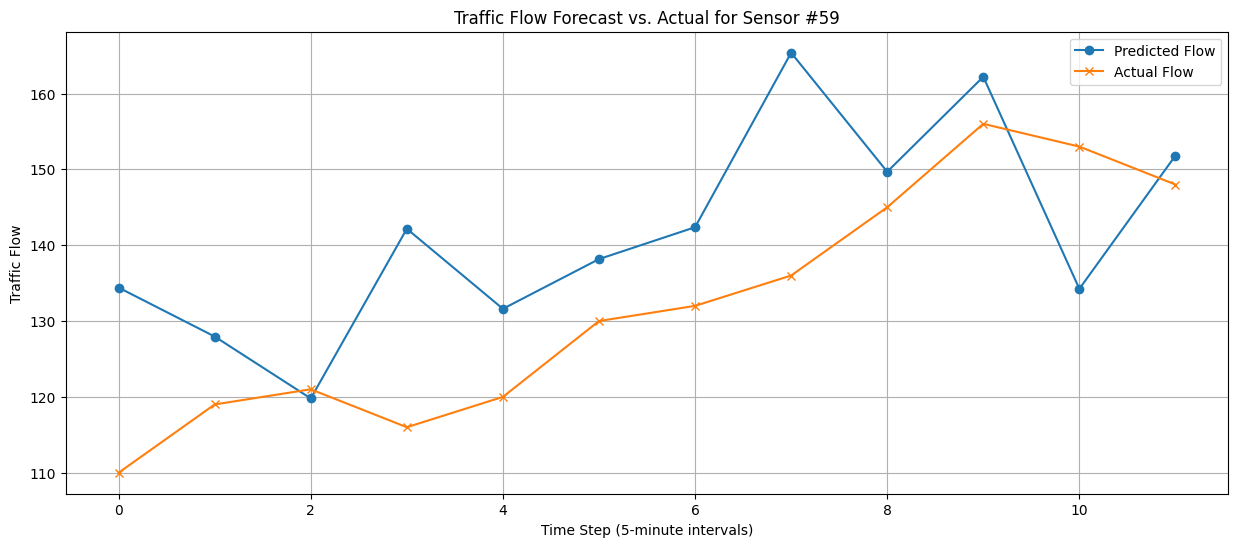

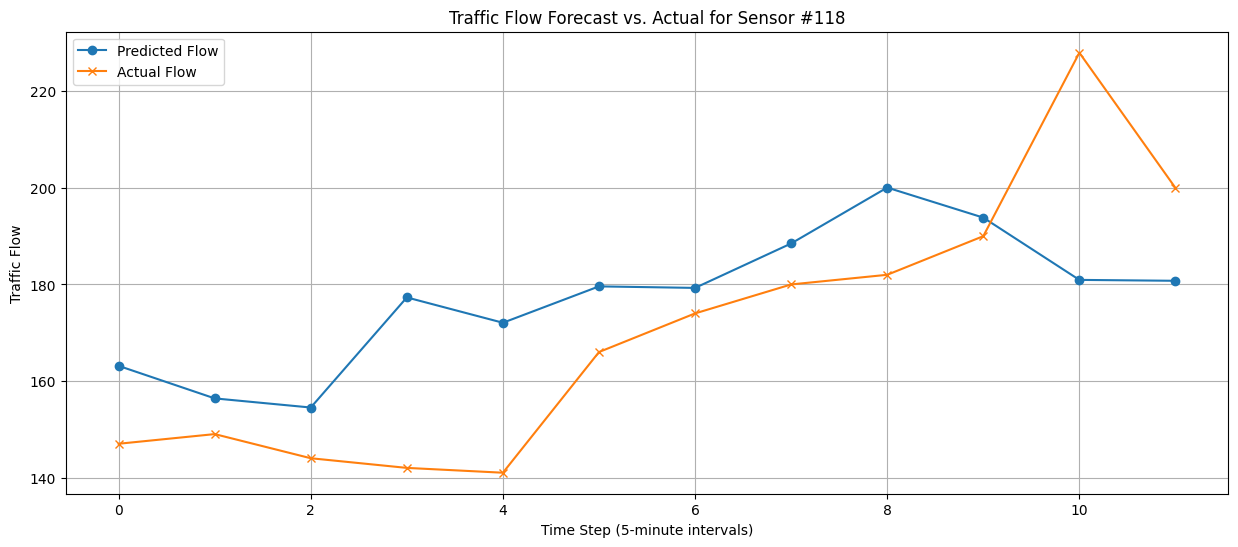

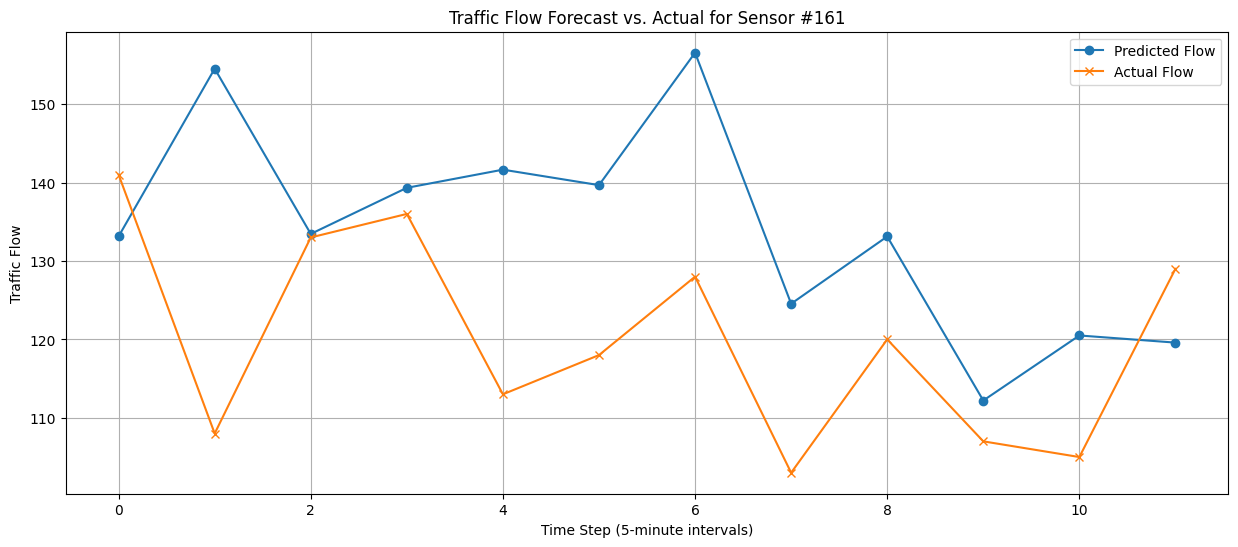

In [ ]:
# Main Execution

if __name__ == '__main__':
    #Data Loading and Preparation
    print("Loading data...")
    traffic_data, dist_matrix = load_data()
    adj_matrix = get_normalized_adj(dist_matrix)
    print("Data loaded and adjacency matrix computed.")

    # Normalize all 3 features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    traffic_data_reshaped = traffic_data.reshape(-1, traffic_data.shape[-1])
    traffic_data_normalized = scaler.fit_transform(traffic_data_reshaped).reshape(traffic_data.shape)
    print("Data normalized using StandardScaler.")

    #Sequence Generation
    seq_length = 12
    pred_length = 12
    print("Generating sequences...")
    X, y = generate_sequences(traffic_data_normalized, seq_length, pred_length)

    print(f"Sequence generation complete. X shape: {X.shape}, y shape: {y.shape}")

    # Data Splitting
    train_split = int(0.7 * len(X))
    val_split = int(0.9 * len(X))
    X_train, y_train = X[:train_split], y[:train_split]
    X_val, y_val = X[train_split:val_split], y[train_split:val_split]
    X_test, y_test = X[val_split:], y[val_split:]
    print(f"Data split. Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Model Building and Training
    print("Building STGCN model...")
    input_shape = X_train.shape[1:]
    model = build_stgcn_model(input_shape, adj_matrix, pred_length)
    model.compile(optimizer='adam', loss='mae')
    model.summary()

    print("\nStarting model training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=32,
        verbose=1
    )
    print("Training complete.")

    #Evaluation and Visualization
    print("\nEvaluating model on test set...")
    test_loss = model.evaluate(X_test, y_test)
    print(f"Test Loss (MAE): {test_loss}")

    print("\n--- Generating Visualization Results ---")
    plot_training_history(history)
    plot_forecasts(model, X_test, y_test, scaler, pred_length)